### github repo for this project: https://github.com/albert-kepner/bbc_news_kaggle/tree/master

In [1]:
import gensim
import nltk
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Data and Exploratory Data Analysis

In [2]:
bbc_train = pd.read_csv('kaggle_data/BBC News Train.csv')
bbc_test = pd.read_csv('kaggle_data/BBC News Test.csv')

In [3]:
list(bbc_train['Category'].unique())

['business', 'tech', 'politics', 'sport', 'entertainment']

In [4]:
bbc_train


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [5]:
## Count occurences of the 5 news categories in the training dataset:
bbc_train['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

## Data Cleaning

In [6]:
## The BBC news text is already in lower case.
## As a first cleaning step I will remove all characters from tokens except lower case alpha and hyphen,
## and then keep only non-empty tokens.
match_non_alpha = re.compile(r'[^-a-z]+')

def clean_words(text):
    tokens = text.split(' ')
    cleaned = []
    for token in tokens:
        new_token = match_non_alpha.sub(r'',token)
        ## Also remove single letter tokens, 
        ## Also remove English stop words from scikit-learn feature_extraction
        if len(new_token) > 1 and new_token not in ENGLISH_STOP_WORDS:
            cleaned.append(new_token)
    clean_text = ' '.join(cleaned)
    return clean_text
        
## function to count words in text
def count_words(text):
    return len (text.split(' '))

In [7]:
bbc_train['CleanedText'] = bbc_train['Text'].apply(clean_words)
bbc_test['CleanedText'] = bbc_test['Text'].apply(clean_words)
display(bbc_train)
display(bbc_test)

,ArticleId,Text,Category,CleanedText
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex-boss launches defence lawyers defe...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses payout eighteen enron directors a...
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,double eviction big brother model caprice holb...
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,dj double act revamp chart dj duo jk joel taki...
1487,1590,weak dollar hits reuters revenues at media gro...,business,weak dollar hits reuters revenues media group ...
1488,1587,apple ipod family expands market apple has exp...,tech,apple ipod family expands market apple expande...


,ArticleId,Text,CleanedText
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads preston queens park range...
1,1319,software watching while you work software that...,software watching work software monitor keystr...
2,1138,d arcy injury adds to ireland woe gordon d arc...,arcy injury adds ireland woe gordon arcy ruled...
3,459,india s reliance family feud heats up the ongo...,india reliance family feud heats ongoing publi...
4,1020,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...
...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,eu probe alitalia state aid european commissio...
731,373,u2 to play at grammy awards show irish rock ba...,play grammy awards irish rock band play live g...
732,1704,sport betting rules in spotlight a group of mp...,sport betting rules spotlight group mps peers ...
733,206,alfa romeos to get gm engines fiat is to sto...,alfa romeos gm engines fiat stop making six-cy...


In [8]:
bbc_train['word_count'] = bbc_train['CleanedText'].apply(count_words)
bbc_test['word_count'] = bbc_test['CleanedText'].apply(count_words)
display(bbc_train)
display(bbc_test)

,ArticleId,Text,Category,CleanedText,word_count
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom ex-boss launches defence lawyers defe...,176
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,175
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...,245
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...,318
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses payout eighteen enron directors a...,184
...,...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,double eviction big brother model caprice holb...,109
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,dj double act revamp chart dj duo jk joel taki...,268
1487,1590,weak dollar hits reuters revenues at media gro...,business,weak dollar hits reuters revenues media group ...,118
1488,1587,apple ipod family expands market apple has exp...,tech,apple ipod family expands market apple expande...,289


,ArticleId,Text,CleanedText,word_count
0,1018,qpr keeper day heads for preston queens park r...,qpr keeper day heads preston queens park range...,78
1,1319,software watching while you work software that...,software watching work software monitor keystr...,212
2,1138,d arcy injury adds to ireland woe gordon d arc...,arcy injury adds ireland woe gordon arcy ruled...,126
3,459,india s reliance family feud heats up the ongo...,india reliance family feud heats ongoing publi...,163
4,1020,boro suffer morrison injury blow middlesbrough...,boro suffer morrison injury blow middlesbrough...,67
...,...,...,...,...
730,1923,eu to probe alitalia state aid the european ...,eu probe alitalia state aid european commissio...,154
731,373,u2 to play at grammy awards show irish rock ba...,play grammy awards irish rock band play live g...,105
732,1704,sport betting rules in spotlight a group of mp...,sport betting rules spotlight group mps peers ...,185
733,206,alfa romeos to get gm engines fiat is to sto...,alfa romeos gm engines fiat stop making six-cy...,147


## Descriptive statistics for word counts in training and test news artitcles after data cleaning

In [9]:
bbc_train['word_count'].describe()

count    1490.000000
mean      194.336242
std       100.689552
min        42.000000
25%       128.000000
50%       172.000000
75%       239.750000
max      1450.000000
Name: word_count, dtype: float64

In [10]:
bbc_test['word_count'].describe()

count     735.000000
mean      201.239456
std       132.890337
min        63.000000
25%       127.000000
50%       173.000000
75%       250.500000
max      1983.000000
Name: word_count, dtype: float64

In [11]:
## Create a list of all (cleaned) words used in the training news articles
## and identify the 25 most frequently occuring words

training_and_test_corpus = list(bbc_train['CleanedText'])
training_and_test_corpus.extend(list(bbc_test['CleanedText']))

display(len(training_and_test_corpus))

all_words = []
for text in training_and_test_corpus:
    all_words.extend(text.split(' '))


top_25 = pd.DataFrame(
    Counter(all_words).most_common(25),
    columns=['word', 'frequency']
)

top_25

2225

,word,frequency
0,said,7254
1,mr,3004
2,people,2043
3,new,1970
4,year,1830
5,world,1186
6,government,1153
7,time,1147
8,uk,1078
9,years,1001


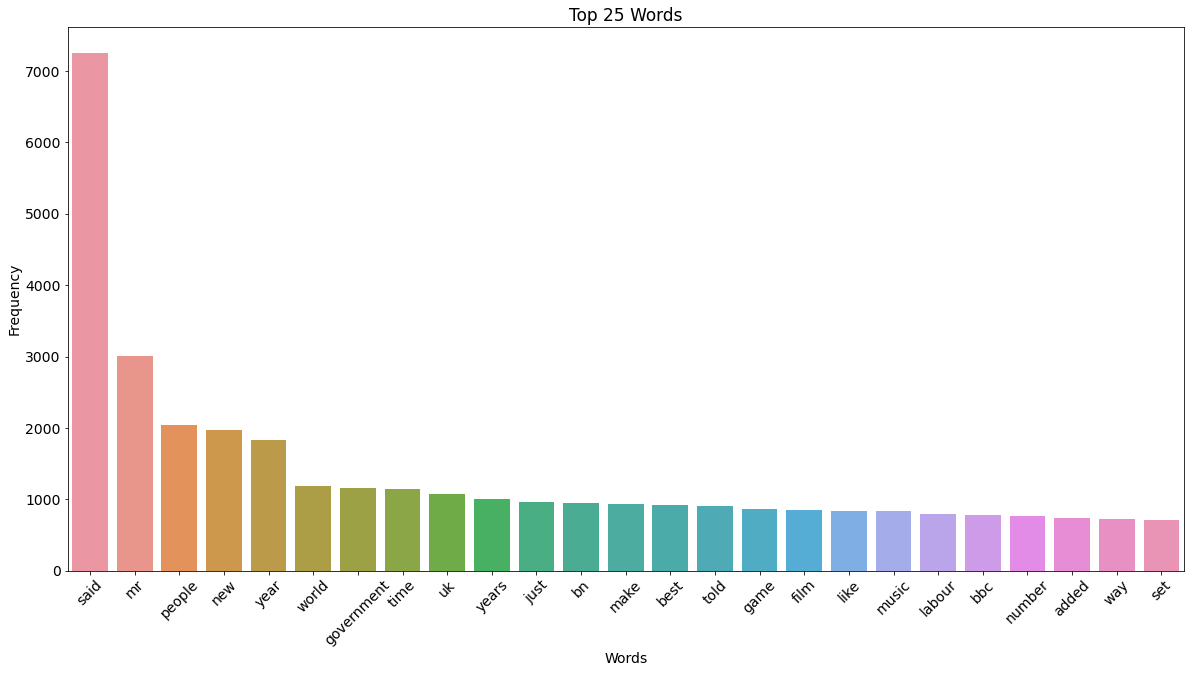

In [12]:
# Plot a bar chart for the top 25 most frequently occuring words
fig = plt.figure(figsize=(20,10))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_25,
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 25 Words', fontsize=17)

plt.show()

# Feature Creation using scikit-learn TF-IDF

## Plan for Modeling with Matrix Factorization

I plan to apply the NMF procedure to a combined matrix using both the training and test documents. We want take advantage of information in both sets of documents to predict which news categories apply to the test documents. Since NMF is an unsupervised method which does not depend on training labels to infer categories, I think we will get a better model by using all the available data in the combined corpus of training and test documents.

We will be using <b>TF-IDF</b> or Term Frequency - Inverse Document Frequency as a way to encode features from the collections of words in each document. The <b>corpus</b> is the set of all words appearing in all documents being considered. A <b>term</b> is a word that appears in the corpus, or a short sequence of specific words. When sequences of words are considered they are called  <b>n-grams</b>. The NGRAM_RANGE defines the minimum and maximum length of the sequences considered.

The ti=f-idf value is proportial to the number of times a term is used in each specific document, and is weighted lower for terms that appear frequently in many documents in the corpus. Terms that appear frequently in given documents may be strong indications of the topics in the document, but terms that appear frequently across many documement provide little specific information.

The scikit-learn TfidfVectorizer determines the frequency of all the terms in the corpus across all documents and across
each specific document being considered. The N most frequet terms in the corpus are used to define a fixed length vector.
This vector is computed for each specific document by computing the tf-idf value of that term in that document for each of the
N most frequent terms in the corpus. This results a fixed-length vector encoding for the collection of words in each document.
The tf-idf vectors for a set of documents are a suitable input for the Nonnegative Matrix Factorization algorithm. The individual tf-idf values are always non-negative.

In [13]:
%%time

## TF-IDF Hyper Parameters which may be tuned

NUMBER_OF_CATEGORIES = 5  ## We know that we need to infer one of 5 news categories
MAX_FEATURES = 5000 ## Build a vocabulary using the only the top max_features ordered by term frequency across the corpus.
MIN_DF = 3 ## Minimum Term Frequency Per Document. Ignore terms that appear less than this number of times in a given document
MAX_DF = 0.85 ## Maximum Document Frequency. Ignore terms that appear in more than this proportion of all documents
NGRAM_RANGE = (1,2)

## Create the tf-idf vectors for all the train and test documents as one corpus
tfidf_vectorizer = TfidfVectorizer(
    min_df=MIN_DF,
    max_df=MAX_DF,
    max_features=MAX_FEATURES,
    ngram_range=NGRAM_RANGE,
)


train_docs = list(bbc_train['CleanedText'])
test_docs = list(bbc_test['CleanedText'])
all_docs = train_docs.copy()
all_docs.extend(test_docs)

train_len =len(train_docs)
test_len = len(test_docs)
all_docs_len = len(all_docs)
print(f'# train docs = {train_len}')
print(f'# test docs = {test_len}')
print(f'# all docs = {all_docs_len}')

tfidf = tfidf_vectorizer.fit_transform(all_docs)

# Save the feature names for later to create topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


# train docs = 1490
# test docs = 735
# all docs = 2225
CPU times: total: 1.38 s
Wall time: 1.39 s


# Matrix Factorization

In [14]:
MAX_NMF_ITERATIONS = 5000

In [15]:
%%time
# Run the nmf model
nmf = NMF(
    n_components=NUMBER_OF_CATEGORIES, ## 5 news categories in these bbc news articles
    init='nndsvd',
    max_iter=MAX_NMF_ITERATIONS,
    l1_ratio=0.0,
    solver='cd',
    alpha_W=0.0, 
    alpha_H='same',
    tol=1e-5,
    random_state=42
).fit(tfidf)

CPU times: total: 922 ms
Wall time: 228 ms


In [19]:
%%time
document_weights = nmf.transform(tfidf_vectorizer.transform(all_docs))
nmf_components = nmf.components_

print(f'nmf_components.shape = {nmf_components.shape}')
print(f'document_weights.shape = {document_weights.shape}')

nmf_components.shape = (5, 5000)
document_weights.shape = (2225, 5)
CPU times: total: 656 ms
Wall time: 590 ms


The original matrix of 2225 documents by 5000 tf-idf weights has been factored (approximately) into the product of two matracies
<b>document_weights</b> ( 2225 x 5 ) times <b>nmf_components</b> (5 by 5000). We want to determine most important terms (by tf-idf weighting) in each of the 5 categories. We will extract the 10 highest weighted terms for each category from the nmf_components matrix.
This can be used as a rough indication of which of the 5 topics is in each of the five categories.





In [20]:
TOP_N_TERMS = 10

def top_term_indices(topic, n_top_terms):
    """
    return the indices of the n top terms in each topic
    """
    return topic.argsort()[:-n_top_terms - 1:-1] 

for topic_index, topic in enumerate(nmf_components):
    print(f'topic_index = {topic_index}')
    topic_top_terms = top_term_indices(topic, TOP_N_TERMS)
    ## We have the indices of the top terms in each topic
    ## Now use these indices to create a list of terms for each topic
    top_terms = [ tfidf_feature_names[idx] for idx in topic_top_terms]
    print(top_terms)

topic_index = 0
['game', 'england', 'win', 'wales', 'cup', 'said', 'ireland', 'play', 'team', 'match']
topic_index = 1
['mr', 'labour', 'blair', 'election', 'brown', 'party', 'said', 'mr blair', 'mr brown', 'government']
topic_index = 2
['bn', 'said', 'growth', 'economy', 'year', 'bank', 'sales', 'oil', 'economic', 'market']
topic_index = 3
['film', 'best', 'awards', 'award', 'actor', 'oscar', 'festival', 'films', 'actress', 'won']
topic_index = 4
['mobile', 'people', 'music', 'said', 'technology', 'phone', 'digital', 'users', 'broadband', 'phones']


The 5 news topics in the BBC News competition are 'business', 'tech', 'politics', 'sport', 'entertainment'.

Given the 10 top terms shown above for each of the 5 topics we can infer a mapping from the topic index in our matracies to
the correct topic name as follows:

In [21]:
topic_index_to_name_map = {0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}
topic_index_to_name_map

{0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}

Since we defined the random_state for the NMF matrix factorization call, the above mapping should remain stable if I rerun this notebook.

The <b>document_weights</b> matrix (2225 by 5) gives a weighting of each of the 5 possible topics in each document. For classification purposes, we just want to find the strongest weight for each document, and use its index as the index of the topic, to look up the topic name.

In [22]:
predicted_indices = np.argmax(document_weights,axis=1)
predicted_topic_names = [topic_index_to_name_map[idx] for idx in predicted_indices]
print(predicted_topic_names)

['business', 'business', 'business', 'tech', 'business', 'politics', 'sport', 'entertainment', 'business', 'entertainment', 'politics', 'entertainment', 'business', 'business', 'sport', 'sport', 'entertainment', 'sport', 'sport', 'tech', 'sport', 'entertainment', 'sport', 'sport', 'tech', 'business', 'tech', 'sport', 'politics', 'business', 'tech', 'tech', 'business', 'politics', 'sport', 'entertainment', 'sport', 'sport', 'sport', 'tech', 'tech', 'sport', 'sport', 'tech', 'entertainment', 'entertainment', 'tech', 'tech', 'tech', 'business', 'tech', 'sport', 'politics', 'sport', 'sport', 'entertainment', 'business', 'business', 'politics', 'sport', 'tech', 'business', 'entertainment', 'tech', 'business', 'sport', 'politics', 'politics', 'tech', 'tech', 'sport', 'tech', 'sport', 'sport', 'sport', 'business', 'sport', 'tech', 'entertainment', 'business', 'tech', 'business', 'politics', 'politics', 'sport', 'sport', 'politics', 'tech', 'sport', 'sport', 'politics', 'tech', 'business', 'sp

In [23]:
## We can split the predicted topics into a training list and a test list.
train_predicted = predicted_topic_names[:train_len]
test_predicted = predicted_topic_names[train_len:]
(len(train_predicted),len(test_predicted))

(1490, 735)

In [24]:
## We can add the predicted topic lists to the pandas data frames bbc_train and bbc_test.
bbc_train['predicted_topic'] = train_predicted
bbc_test['predited_topic'] = test_predicted

In [25]:
## We can measure the accuracy of the predictions on the training data
accuracy = np.sum(bbc_train['Category']==bbc_train['predicted_topic'])/train_len
print (f'accuracy = {accuracy}')

accuracy = 0.9208053691275168


In [26]:
## We need to create a submission file to submit the test predictions to Kaggle for the competition.
submission_df = pd.DataFrame(bbc_test['ArticleId'])
submission_df['Category'] = test_predicted
display(submission_df)
submission_df.to_csv('./kaggle_data/Submission2.csv',index=False)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,tech
733,206,business


### Submitting the above file to Kaggle resulted in an accuracy  Score: 0.92925 on the test data set.

# Step 2: Building and training BBC News NMF models -- Summary

The NMF model built so far in this notebook uses a TfidfVectorizer with the top 5000 term features, and using N_GRAMS of length 1 and 2. The document versus term weight matrix was then factored using the NMF algorithm, and targeting 5 topics. By inspecting the most frequent terms in each of the 5 topics, we identified which topic in the matracies corresponds with each of the 5 BBC News categories. Then by examining the matrix <b>document_weights</b> (dimension 5 topics by #documents) we were able to predict which topic goes with each document just by finding the highest topic weight per document.

Initially this produced an accuracy of 0.92081 on the training documents and a Kaggle accuracy score of 0.92925 on the test documents.

To improve this model I tried increasing the MAX_FEATURES used in the TfidfVectorizer and at the same time increasing the length of the N_GRAMS used as terms in the model. The results are shown in the following table:

In [27]:
df = pd.read_excel('data/TFIDF_Feature_Comparison.xlsx')
display(df)

,MODEL,TF-IDF MAX_FEATURES,Actual Features Used,N_GRAM RANGE,Train Accuracy,Test Accuracy
0,1,5000,5000,"(1,2)",0.92081,0.92925
1,2,20000,20000,"(1,3)",0.92483,0.93333
2,3,50000,36381,"(1,4)",0.92818,0.93333
3,4,100000,37988,"(1,5)",0.92886,0.93333


As can be seen in the table above, the model NMF model accuracy was slightly increased by using larger numbers of TF-IDF terms.

The training runs for models 2, 3, and 4, were done in separate notebooks which can be seen in my github repo here:

* Model 2 -- https://github.com/albert-kepner/bbc_news_kaggle/blob/master/BBC_News_Model2.ipynb
* Model 3 -- https://github.com/albert-kepner/bbc_news_kaggle/blob/master/BBC_News_Model3.ipynb
* Model 4 -- https://github.com/albert-kepner/bbc_news_kaggle/blob/master/BBC_News_Model4.ipynb

# Step 3: Compare with supervised learning -- Random Forest Model

For supervised learning, I built a Random Forest Model. This was developed in a separate notbook here:

https://github.com/albert-kepner/bbc_news_kaggle/blob/master/Random_Forest_Model.ipynb

For hyperparameter tuning I experimented with a range of values for N_ESTIMATORS and MAX_DEPTH in the Random Forest Models. To 
tune these models on the training data set I used the out-of-bag score. Based on trying the combinations of parameters shown <b>below</b>, I decided that N_ESTIMATORS = 20,000 and MAX_DEPTH = 20 worked best, given that further increases made model training slower, but did not increase the out-of-bag score. This model has an accuracy of 0.9993 on the full training data set. However I do not think this indicates excessive overfitting since it was tuned on the out-of-bag score, and ensemble models like this tend to generalize fairly well.

This RF model produced a score of 0.95981 on the test data, when submitted to Kaggle. So not too suprisingly this supervised model performed better than the NMF model on both training accuracy and test accuracy.

In [35]:
df = pd.read_excel('data/Random_Forest_Model_Tuning.xlsx')
display(df)

,N_ESTIMATORS,MAX_DEPTH,OOB SCORE
0,15000,15,0.946
1,20000,15,0.948
2,15000,20,0.952
3,15000,25,0.953
4,20000,20,0.953
5,20000,25,0.953
6,25000,20,0.953


One example of training this model is shown below:

In [36]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## Tunable parameters
N_ESTIMATORS=20000
MAX_DEPTH=20
N_JOBS=-1

model = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    oob_score=True,
    n_jobs=N_JOBS,
)
document_features = tfidf_vectorizer.transform(all_docs)
train_features = document_features[:train_len,:]
test_features = document_features[train_len:,:]
model.fit(train_features, bbc_train['Category'])

print(f'{model.oob_score_=}')

y_pred = model.predict(train_features)
train_accuracy = accuracy_score(bbc_train['Category'], y_pred)
print(f'{train_accuracy=}')

model.oob_score_=0.9516778523489933
train_accuracy=0.9993288590604027
CPU times: total: 2min 41s
Wall time: 53.8 s


In [37]:
## We need to create a submission file to submit the test predictions to Kaggle for the competition.
test_predicted = model.predict(test_features)
submission_df = pd.DataFrame(bbc_test['ArticleId'])
submission_df['Category'] = test_predicted
display(submission_df)
submission_df.to_csv('./kaggle_data/Submission6.csv',index=False)

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport
...,...,...
730,1923,business
731,373,entertainment
732,1704,business
733,206,business


## Submitting this model's predictions to Kaggle produced an accuracy score of 0.95918 on the test data.

# Step 3: Part 2, How does the Supervised ML model decrease in accuracy with fewer labels?

In the last part of this notebook: https://github.com/albert-kepner/bbc_news_kaggle/blob/master/Random_Forest_Model.ipynb
I ran an experiment where I trained the same Random Forest model on decreasing fractions of the availble trainging data.
The fractions were 50%, 20%, 10%, and 5% using train_test_split. The fraction not used for training was used to calculate an accuracy score in each case. Each experiment was run 10 times and the accuracy results averaged. The results are shown in the table below. The accuracy of the Random Forest models decreased when using fewer samples, as expected. But this model was suprisingly robust when trained with as few as 5% of the original training data.

In [40]:
df = pd.read_csv('data/AccuracyVersusFractionOfLabelsUsed')
display(df.sort_values(by='label_fraction',ascending=False))

,label_fraction,accuracy
3,0.50,0.942
2,0.20,0.930
1,0.10,0.865
0,0.05,0.741


# Part 2 Use Non-Negative Matrix Factorization on the Movie Ratings Data set

I loaded the movie data from Homework 3 and also the best collaborative model in the notebook here:
    
https://github.com/albert-kepner/bbc_news_kaggle/blob/master/NMF_for_MovieRatings.ipynb

The best collaborative model produced an RMSE of about 0.9509.

I noted that in the Movie Ratings matrix (dimensions 6040 users by 3883 movies) that missing values (movies not rated by a given user) were represented as 0, with ratings in the range 1 to 5. Also about 97% of the ratings were missing, so that on average each user had rated about 3% of the movies. Rather than using this matrix directly, I imputed all the zero values as the average movie rating for each given user and then applied NMF factorization to the resulting matrix, assumming we wanted 18 features to represent the 18 movie genres.

With the factored matrices I had a 6040 by 18 matrix representing weight each user placed on each genre and an 18 by 3883 matrix representing the relative weight of each genre in each movie. I then predicted the rating of each user for each move in the test data set by taking the dot product of the user's row in the first matrix by the movie's column in the 2nd matrix.

Suprisingly this prediction produced an RSME of 0.9695, which was almost as good as the best collaborative model. However the NMF based prediction would have been much worse had I used the movie ratings matrix directly with all the zero values for missing data.

## References

1. Topic Modeling Articles with NMF https://towardsdatascience.com/topic-modeling-articles-with-nmf-8c6b2a227a45
2. Public github https://github.com/robsalgado/personal_data_science_projects/tree/master/topic_modeling_nmf
3. TF-IDF https://en.wikipedia.org/wiki/Tf%E2%80%93idf